## SARIMA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
name = "AAL" # Airline group

df = yf.download(tickers=name, start="2005-01-01", end="2020-01-01" ,interval="1mo", auto_adjust=True, prepost=False)

df.drop("Volume", axis=1, inplace=True)
df["Price"] = df.mean(axis=1)
dataReal = pd.Series(df["Price"])
dataReal = dataReal.dropna()

[*********************100%***********************]  1 of 1 completed


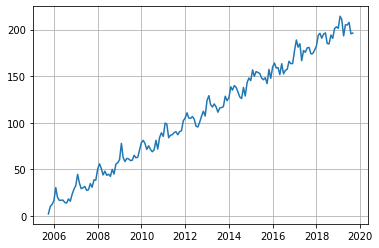

In [5]:
np.random.seed(42)
def dataCurve(realData):
    s = [1,4,5,7,12,8,5,4,3,2,1,3]
    years = int(realData.size/12)
    s = s*years
    fake = pd.Series([(s[x]+x/5)*(np.random.randint(70,130)/100)+s[x]+x for x in range(len(s))])
    fake.index = realData.iloc[:len(s)].index
    return fake
data = dataCurve(dataReal)
plt.grid()
plt.plot(data)

Fake data and real data

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


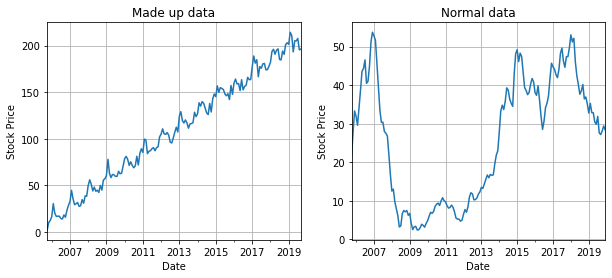

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.ylabel("Stock Price")

data.plot(title="Made up data")
plt.grid()
plt.subplot(1, 2, 2)
plt.ylabel("Stock Price")
dataReal.plot(title="Normal data")
plt.grid()

Spitting the data into a training and testing part.

In [7]:
allData = data.copy()
data = data[:int(data.size*0.85)]

In [8]:
resAd = adfuller(data)
print(resAd)

(-0.07935212193216723, 0.9514567006453201, 11, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 771.8992735578842)


ACF and PACF for the real data

(-8.490035554122674, 1.321051845361538e-13, 0, 169, {'1%': -3.469648263987657, '5%': -2.878798906308495, '10%': -2.5759713094779593}, 678.3858287314557)


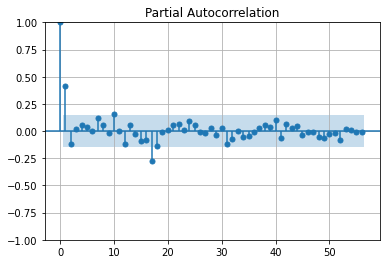

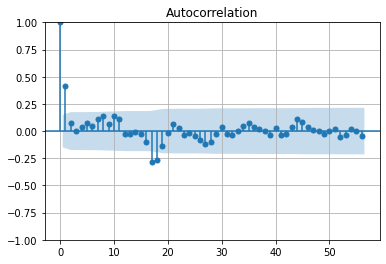

In [9]:
m = 1
diffRealData = dataReal-dataReal.shift(m)
diffRealData = diffRealData.dropna()

resAdReal = adfuller(diffRealData)
print(resAdReal)

lagsReal = diffRealData.size/3
plot_pacf(diffRealData, method="ywm", lags=lagsReal);
plt.grid()
plot_acf(diffRealData, lags=lagsReal);
plt.grid()

View PACF and PAC for the made up data.

(-12.205790459015905, 1.1944657688804925e-22, 10, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 764.9728936589701)


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


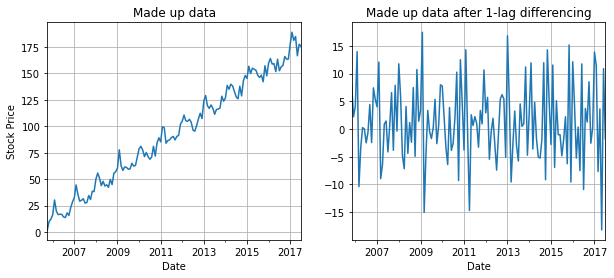

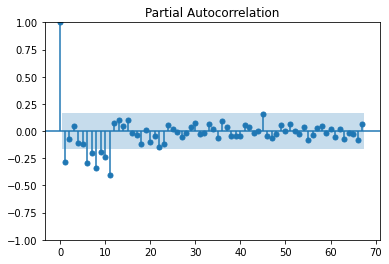

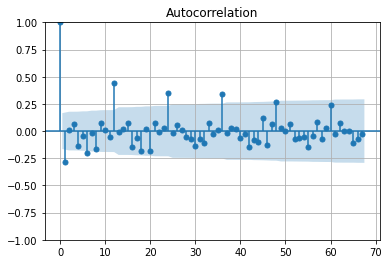

In [10]:
m = 1
diffData = data-data.shift(m)
diffData = diffData.dropna()

resAd = adfuller(diffData)
print(resAd)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.ylabel("Stock Price")
data.plot(title="Made up data")
plt.grid()
plt.subplot(1, 2, 2)
diffData.plot(title=f"Made up data after {m}-lag differencing")
plt.grid()

plot_pacf(diffData, method="ywm", lags=diffData.size/2.1);
plt.grid()
plot_acf(diffData, lags=diffData.size/2.1);
plt.grid()

In [11]:
model = ARIMA(data, order=(2,2,1))
arima_fit = model.fit()
summary = arima_fit.summary()
print(summary)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -465.319
Date:                Sun, 15 May 2022   AIC                            938.638
Time:                        21:13:08   BIC                            950.404
Sample:                    10-01-2005   HQIC                           943.419
                         - 07-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3007      0.093     -3.235      0.001      -0.483      -0.119
ar.L2         -0.0688      0.098     -0.699      0.485      -0.262       0.124
ma.L1         -1.0000     27.534     -0.036      0.9

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


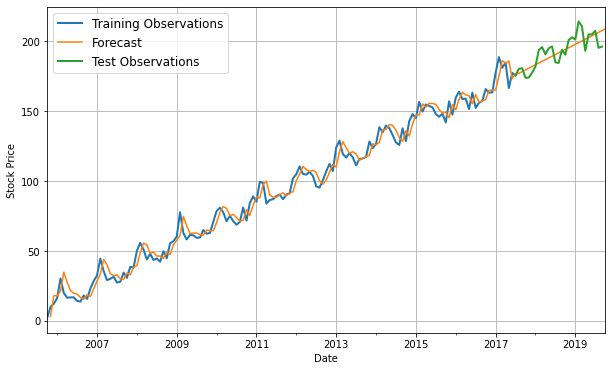

In [12]:
plt.figure(figsize=(10,6))
plt.ylabel("Stock Price")
allData.iloc[:data.size].plot(linewidth=2, label="Training Observations")
arima_predict = arima_fit.predict(start=1, end=allData.size)
arima_predict.plot(label="Forecast")
allData.iloc[data.size-1:].plot(linewidth=2, label="Test Observations")
plt.grid()
plt.legend(fontsize="12")

In [17]:
model = SARIMAX(data, order=(2,2,1), seasonal_order=(0,2,2,12), method_kwargs={"UserWarning": False}) #, trend_offset=12)
sarima_fit = model.fit(maxiter=200)
summary = sarima_fit.summary()
print(summary)

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  142
Model:             SARIMAX(2, 2, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -375.028
Date:                                 Sun, 15 May 2022   AIC                            762.057
Time:                                         21:13:31   BIC                            778.578
Sample:                                     10-01-2005   HQIC                           768.764
                                          - 07-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6653      0.101     -6.597      0.000      -0.863      -0

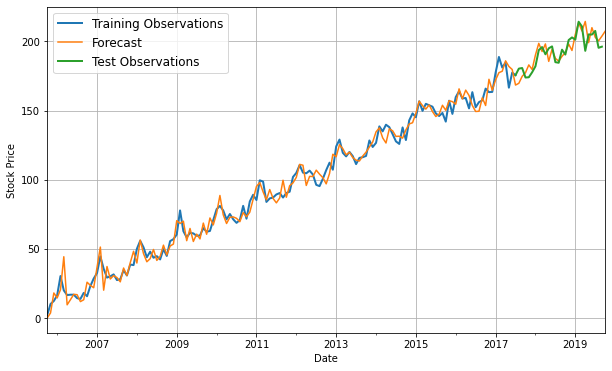

In [15]:
plt.figure(figsize=(10,6))
plt.ylabel("Stock Price")
allData.iloc[:data.size].plot(linewidth=2, label="Training Observations")
sarima_predict = sarima_fit.predict(start=0, end=allData.size)
sarima_predict.plot(label="Forecast")
allData.iloc[data.size-1:].plot(linewidth=2, label="Test Observations")
plt.grid()
plt.legend(fontsize="12");